In [0]:
!pip install torch torchvision

    100% |████████████████████████████████| 61kB 2.4MB/s 
    100% |████████████████████████████████| 2.0MB 12.1MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
  [PIL]
You must restart the runtime in order to use newly installed versions.


In [0]:
# Load zip from Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
!unzip gdrive/My\ Drive/data_semantics.zip

In [0]:
#os.chdir('./content/')
!ls

gdrive	sample_data  testing  training


In [0]:
!tar -xvzf gdrive/My\ Drive/iccv09Data.tar.gz

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm

In [0]:
class InitialBlock(nn.Module):
    def __init__ (self,in_channels = 3,out_channels = 13):
        super().__init__()


        self.maxpool = nn.MaxPool2d(kernel_size=2, 
                                      stride = 2, 
                                      padding = 0)

        self.conv = nn.Conv2d(in_channels, 
                                out_channels,
                                kernel_size = 3,
                                stride = 2, 
                                padding = 1)

        self.prelu = nn.PReLU()

        self.batchnorm = nn.BatchNorm2d(out_channels)
  
    def forward(self, x):
        
        main = self.conv(x)
        main = self.batchnorm(main)
        main = self.prelu(main)
        
        side = self.maxpool(x)
        
        x = torch.cat((main, side), dim=1)
        
        return x

In [0]:
class UBNeck(nn.Module):
    def __init__(self, in_channels, out_channels, projection_ratio=4):
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        self.reduced_depth = int(in_channels / projection_ratio)
        self.out_channels = out_channels
        
        self.unpool = nn.MaxUnpool2d(kernel_size = 2,
                                     stride = 2)
        
        self.main_conv = nn.Conv2d(in_channels = self.in_channels,
                                    out_channels = self.out_channels,
                                    kernel_size = 1)
        
        self.dropout = nn.Dropout2d(p=0.1)
        
        self.convt1 = nn.ConvTranspose2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = 1,
                               padding = 0,
                               bias = False)
        
        
        self.prelu1 = nn.PReLU()
        
        self.convt2 = nn.ConvTranspose2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = 3,
                                  stride = 2,
                                  padding = 1,
                                  output_padding = 1,
                                  bias = False)
        
        self.prelu2 = nn.PReLU()
        
        self.convt3 = nn.ConvTranspose2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  padding = 0,
                                  bias = False)
        
        self.prelu3 = nn.PReLU()
        
        self.batchnorm = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        
    def forward(self, x, indices):
        x_copy = x
        
        # Side Branch
        x = self.convt1(x)
        x = self.batchnorm(x)
        x = self.prelu1(x)
        
        x = self.convt2(x)
        x = self.batchnorm(x)
        x = self.prelu2(x)
        
        x = self.convt3(x)
        x = self.batchnorm2(x)
        
        x = self.dropout(x)
        
        # Main Branch
        
        x_copy = self.main_conv(x_copy)
        x_copy = self.unpool(x_copy, indices, output_size=x.size())
        
        # Concat
        x = x + x_copy
        x = self.prelu3(x)
        
        return x

In [0]:
class RDDNeck(nn.Module):
    def __init__(self, dilate, in_channels, out_channels, down_flag, projection_ratio=4, p=0.1):
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        
        self.out_channels = out_channels
        self.dilate = dilate
        self.down_flag = down_flag

        if down_flag:
            self.stride = 2
            self.reduced_depth = int(in_channels // projection_ratio)
        else:
            self.stride = 1
            self.reduced_depth = int(out_channels // projection_ratio)
        
        self.maxpool = nn.MaxPool2d(kernel_size = 2,
                                      stride = 2,
                                      padding = 0, return_indices=True)
        

        
        self.dropout = nn.Dropout2d(p=p)

        self.conv1 = nn.Conv2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = 1,
                               stride = 1,
                               padding = 0,
                               bias = False,
                               dilation = 1)
        
        self.prelu1 = nn.PReLU()
        
        self.conv2 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = 3,
                                  stride = self.stride,
                                  padding = self.dilate,
                                  bias = True,
                                  dilation = self.dilate)
                                  
        self.prelu2 = nn.PReLU()
        
        self.conv3 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  stride = 1,
                                  padding = 0,
                                  bias = False,
                                  dilation = 1)
        
        self.prelu3 = nn.PReLU()
        
        self.batchnorm = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        
        
    def forward(self, x):
        
        bs = x.size()[0]
        x_copy = x
        
        # Side Branch
        x = self.conv1(x)
        x = self.batchnorm(x)
        x = self.prelu1(x)
        
        x = self.conv2(x)
        x = self.batchnorm(x)
        x = self.prelu2(x)
        
        x = self.conv3(x)
        x = self.batchnorm2(x)
                
        x = self.dropout(x)
        
        # Main Branch
        if self.down_flag:
            x_copy, indices = self.maxpool(x_copy)
          
        if self.in_channels != self.out_channels:
            out_shape = self.out_channels - self.in_channels
            extras = torch.zeros((bs, out_shape, x.shape[2], x.shape[3]))
            if torch.cuda.is_available():
                extras = extras.cuda()
            x_copy = torch.cat((x_copy, extras), dim = 1)

        # Sum of main and side branches
        x = x + x_copy
        x = self.prelu3(x)
        
        if self.down_flag:
            return x, indices
        else:
            return x

In [0]:
class ASNeck(nn.Module):
    def __init__(self, in_channels, out_channels, projection_ratio=4):
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        self.reduced_depth = int(in_channels / projection_ratio)
        self.out_channels = out_channels
        
        self.dropout = nn.Dropout2d(p=0.1)
        
        self.conv1 = nn.Conv2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = 1,
                               stride = 1,
                               padding = 0,
                               bias = False)
        
        self.prelu1 = nn.PReLU()
        
        self.conv21 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = (1, 5),
                                  stride = 1,
                                  padding = (0, 2),
                                  bias = False)
        
        self.conv22 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = (5, 1),
                                  stride = 1,
                                  padding = (2, 0),
                                  bias = False)
        
        self.prelu2 = nn.PReLU()
        
        self.conv3 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  stride = 1,
                                  padding = 0,
                                  bias = False)
        
        self.prelu3 = nn.PReLU()
        
        self.batchnorm = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        
    def forward(self, x):
        bs = x.size()[0]
        x_copy = x
        
        # Side Branch
        x = self.conv1(x)
        x = self.batchnorm(x)
        x = self.prelu1(x)
        
        x = self.conv21(x)
        x = self.conv22(x)
        x = self.batchnorm(x)
        x = self.prelu2(x)
        
        x = self.conv3(x)
                
        x = self.dropout(x)
        x = self.batchnorm2(x)
        
        # Main Branch
        
        if self.in_channels != self.out_channels:
            out_shape = self.out_channels - self.in_channels
            extras = torch.zeros((bs, out_shape, x.shape[2], x.shape[3]))
            if torch.cuda.is_available():
                extras = extras.cuda()
            x_copy = torch.cat((x_copy, extras), dim = 1)
        
        # Sum of main and side branches
        x = x + x_copy
        x = self.prelu3(x)
        
        return x

In [0]:
class ENet(nn.Module):
    def __init__(self, C):
        super().__init__()
        
        # Define class variables
        self.C = C
        
        self.init = InitialBlock()
        
        self.b10 = RDDNeck(1, 16, 64, True, p=0.01)
        self.b11 = RDDNeck(1, 64, 64, False, p=0.01)
        self.b12 = RDDNeck(1, 64, 64, False, p=0.01)
        self.b13 = RDDNeck(1, 64, 64, False, p=0.01)
        self.b14 = RDDNeck(1, 64, 64, False, p=0.01)
        
        self.b20 = RDDNeck(1, 64, 128, True)
        self.b21 = RDDNeck(1, 128, 128, False)
        self.b22 = RDDNeck(2, 128, 128, False)
        self.b23 = ASNeck(128, 128)
        self.b24 = RDDNeck(4, 128, 128, False)
        self.b25 = RDDNeck(1, 128, 128, False)
        self.b26 = RDDNeck(8, 128, 128, False)
        self.b27 = ASNeck(128, 128)
        self.b28 = RDDNeck(16, 128, 128, False)
        
        self.b31 = RDDNeck(1, 128, 128, False)
        self.b32 = RDDNeck(2, 128, 128, False)
        self.b33 = ASNeck(128, 128)
        self.b34 = RDDNeck(4, 128, 128, False)
        self.b35 = RDDNeck(1, 128, 128, False)
        self.b36 = RDDNeck(8, 128, 128, False)
        self.b37 = ASNeck(128, 128)
        self.b38 = RDDNeck(16, 128, 128, False)
        
        self.b40 = UBNeck(128, 64)
        self.b41 = RDDNeck(1, 64, 64, False)
        self.b42 = RDDNeck(1, 64, 64, False)
        
        self.b50 = UBNeck(64, 16)
        self.b51 = RDDNeck(1, 16, 16, False)
        
        self.fullconv = nn.ConvTranspose2d(in_channels=16, 
                                           out_channels=self.C, 
                                           kernel_size=3, 
                                           stride=2, 
                                           padding=1, 
                                           output_padding=1,
                                           bias=False)
        
        #self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        
        x = self.init(x)
        
        x, i1 = self.b10(x)
        x = self.b11(x)
        x = self.b12(x)
        x = self.b13(x)
        x = self.b14(x)
        
        x, i2 = self.b20(x)
        x = self.b21(x)
        x = self.b22(x)
        x = self.b23(x)
        x = self.b24(x)
        x = self.b25(x)
        x = self.b26(x)
        x = self.b27(x)
        x = self.b28(x)
        
        x = self.b31(x)
        x = self.b32(x)
        x = self.b33(x)
        x = self.b34(x)
        x = self.b35(x)
        x = self.b36(x)
        x = self.b37(x)
        x = self.b38(x)
        
        x = self.b40(x, i2)
        x = self.b41(x)
        x = self.b42(x)
        
        x = self.b50(x, i1)
        x = self.b51(x)
        
        x = self.fullconv(x)
        #x = self.softmax(x)
        
        return x

In [0]:
color_map = [
    (  0,  0,  0) ,
    (111, 74,  0) ,
    ( 81,  0, 81) ,
    (128, 64,128) ,
    (244, 35,232) ,
    (250,170,160) ,
    (230,150,140),
    ( 70, 70, 70) ,
    (102,102,156) ,
    (190,153,153),
    (180,165,180) ,
    (150,100,100) ,
    (150,120, 90) ,
    (153,153,153) ,
    (250,170, 30),
    (220,220,  0),
    (107,142, 35),
    (152,251,152),
    ( 70,130,180),
    (220, 20, 60),
    (255,  0,  0),
    (  0,  0,142),
    (  0,  0, 70),
    (  0, 60,100),
    (  0,  0, 90),
    (  0,  0,110),
    (  0, 80,100),
    (  0,  0,230),
    (119, 11, 32)
]

In [0]:
def create_mask(img):
  color_map = [
    (  0,  0,  0) ,
    (111, 74,  0) ,
    ( 81,  0, 81) ,
    (128, 64,128) ,
    (244, 35,232) ,
    (250,170,160) ,
    (230,150,140),
    ( 70, 70, 70) ,
    (102,102,156) ,
    (190,153,153),
    (180,165,180) ,
    (150,100,100) ,
    (150,120, 90) ,
    (153,153,153) ,
    (250,170, 30),
    (220,220,  0),
    (107,142, 35),
    (152,251,152),
    ( 70,130,180),
    (220, 20, 60),
    (255,  0,  0),
    (  0,  0,142),
    (  0,  0, 70),
    (  0, 60,100),
    (  0,  0, 90),
    (  0,  0,110),
    (  0, 80,100),
    (  0,  0,230),
    (119, 11, 32)
]

  mask = []
  for i in color_map:
    color_img = []
    for j in range(3):
      color_img.append(np.ones((img.shape[:-1])) * i[j]) 
    
    img2 = np.array(color_img, dtype=np.uint8).transpose(1, 2, 0)
    
    mask.append(np.uint8((img == img2).sum(axis = -1) == 3))
  return np.array(mask)

In [0]:
def read_resized_imgs(ImageDirPath,Semantic_flag):
  #os.chdir(ImageDirPath)
  images = []
  for i in os.listdir(ImageDirPath):
    if '.png' in i:
      img = cv2.cvtColor(cv2.imread(ImageDirPath + i), cv2.COLOR_BGR2RGB)
      img = cv2.resize(img,(640, 360), cv2.INTER_CUBIC)
      images.append(img)
      
  if Semantic_flag:
    images = list(map(create_mask, images))
    
  return np.array(images)

In [0]:
def data_pipeline(images,images_mask, batch_size = 16):
    while(1):
        batch_indx = np.random.randint(0,images.shape[0]-1,batch_size)
        #inputs, labels = 
        yield(torch.from_numpy(images[batch_indx]).transpose(2, 3).transpose(1, 2), 
              torch.from_numpy(images_mask[batch_indx]))

In [0]:
images = read_resized_imgs('/content/training/image_2/', False)
images_mask = read_resized_imgs('/content/training/semantic_rgb/', True)

In [0]:
enet2 = ENet(29)
state_dict = torch.load('/content/ckpt-enet-1.pth')['state_dict']
enet2.load_state_dict(state_dict)

In [0]:
enet = ENet(29)

In [0]:
lr = 5e-4
#lr = 1e-4 
batch_size = 10

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
enet = enet.to(device)

In [0]:
#criterion = nn.BCELoss()
weights = [1.0, 1.0, 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 
           1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., ]
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(weights).to(device))
optimizer = torch.optim.Adam(enet.parameters(), 
                             lr=lr,
                             weight_decay=2e-4)

In [0]:
CUDA_LAUNCH_BLOCKING=1

In [0]:
#0

cuda =  torch.cuda.is_available()

print_every = 5
train_losses = []

#batch_count = images.shape[0] // batch_size
batch_count = 200 // batch_size

#pipe = data_pipeline(images, images_mask, batch_size)
pipe = loader('/content/training/image_2/', '/content/training/semantic/', batch_size)

epochs = 660
    
enet.train()
for e in range(1, epochs+1):

    train_loss = 0
    print ('-'*15,'Epoch %d' % e, '-'*15)

    for _ in tqdm(range(batch_count)):
        X_batch, mask_batch = next(pipe)
        
        #assert (X_batch >= 0. and X_batch <= 1.0).all()
        
        if cuda:
            X_batch, mask_batch = X_batch.cuda(), mask_batch.cuda()

        enet.zero_grad()

        out = enet(X_batch.float())

        loss = criterion(out, mask_batch.long())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print ()
    train_losses.append(train_loss)

    #if (e+1) % print_every == 0:
    if 5 % print_every == 0:

        print ('Epoch {}/{}...'.format(e+1, epochs),
                'Loss {:6f}'.format(train_loss))
        
    if e % print_every == 0:
        checkpoint = {
            'epochs' : e,
            'state_dict' : enet.state_dict()
        }
        torch.save(checkpoint, '/content/ckpt-enet-{}-{}.pth'.format(e, train_loss))
        print ('Model saved!')

print ('Epoch {}/{}...'.format(e+1, epochs),
       'Total Mean Loss: {:6f}'.format(sum(train_losses) / epochs))

  0%|          | 0/20 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------
200


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 2/660... Loss 0.007926
--------------- Epoch 2 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 3/660... Loss 0.008767
--------------- Epoch 3 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 4/660... Loss 0.008418
--------------- Epoch 4 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 5/660... Loss 0.008006
--------------- Epoch 5 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 6/660... Loss 0.008152
Model saved!
--------------- Epoch 6 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 7/660... Loss 0.007241
--------------- Epoch 7 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 8/660... Loss 0.010107
--------------- Epoch 8 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 9/660... Loss 0.008956
--------------- Epoch 9 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 10/660... Loss 0.007239
--------------- Epoch 10 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 11/660... Loss 0.008023
Model saved!
--------------- Epoch 11 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 12/660... Loss 0.008072
--------------- Epoch 12 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 13/660... Loss 0.008026
--------------- Epoch 13 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 14/660... Loss 0.007644
--------------- Epoch 14 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 15/660... Loss 0.007916
--------------- Epoch 15 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 16/660... Loss 0.008872
Model saved!
--------------- Epoch 16 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 17/660... Loss 0.008170
--------------- Epoch 17 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 18/660... Loss 0.008138
--------------- Epoch 18 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 19/660... Loss 0.007853
--------------- Epoch 19 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 20/660... Loss 0.008163
--------------- Epoch 20 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 21/660... Loss 0.007646
Model saved!
--------------- Epoch 21 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 22/660... Loss 0.007945
--------------- Epoch 22 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 23/660... Loss 0.008100
--------------- Epoch 23 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 24/660... Loss 0.007216
--------------- Epoch 24 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 25/660... Loss 0.007487
--------------- Epoch 25 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 26/660... Loss 0.007540
Model saved!
--------------- Epoch 26 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 27/660... Loss 0.007597
--------------- Epoch 27 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 28/660... Loss 0.007486
--------------- Epoch 28 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 29/660... Loss 0.007872
--------------- Epoch 29 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 30/660... Loss 0.007778
--------------- Epoch 30 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 31/660... Loss 0.007311
Model saved!
--------------- Epoch 31 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 32/660... Loss 0.007695
--------------- Epoch 32 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 33/660... Loss 0.007698
--------------- Epoch 33 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 34/660... Loss 0.007491
--------------- Epoch 34 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 35/660... Loss 0.007851
--------------- Epoch 35 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 36/660... Loss 0.007805
Model saved!
--------------- Epoch 36 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 37/660... Loss 0.007150
--------------- Epoch 37 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 38/660... Loss 0.007766
--------------- Epoch 38 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 39/660... Loss 0.008242
--------------- Epoch 39 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 40/660... Loss 0.007048
--------------- Epoch 40 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 41/660... Loss 0.007026
Model saved!
--------------- Epoch 41 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 42/660... Loss 0.007340
--------------- Epoch 42 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 43/660... Loss 0.007308
--------------- Epoch 43 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 44/660... Loss 0.007732
--------------- Epoch 44 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 45/660... Loss 0.007791
--------------- Epoch 45 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 46/660... Loss 0.007495
Model saved!
--------------- Epoch 46 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 47/660... Loss 0.006914
--------------- Epoch 47 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 48/660... Loss 0.007436
--------------- Epoch 48 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 49/660... Loss 0.007140
--------------- Epoch 49 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 50/660... Loss 0.007850
--------------- Epoch 50 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 51/660... Loss 0.007530
Model saved!
--------------- Epoch 51 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 52/660... Loss 0.007293
--------------- Epoch 52 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 53/660... Loss 0.007188
--------------- Epoch 53 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 54/660... Loss 0.007109
--------------- Epoch 54 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 55/660... Loss 0.008182
--------------- Epoch 55 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 56/660... Loss 0.007732
Model saved!
--------------- Epoch 56 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 57/660... Loss 0.006688
--------------- Epoch 57 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 58/660... Loss 0.007071
--------------- Epoch 58 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 59/660... Loss 0.007410
--------------- Epoch 59 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 60/660... Loss 0.007123
--------------- Epoch 60 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 61/660... Loss 0.007510
Model saved!
--------------- Epoch 61 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 62/660... Loss 0.007605
--------------- Epoch 62 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 63/660... Loss 0.007163
--------------- Epoch 63 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 64/660... Loss 0.006982
--------------- Epoch 64 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 65/660... Loss 0.007162
--------------- Epoch 65 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 66/660... Loss 0.009088
Model saved!
--------------- Epoch 66 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 67/660... Loss 0.006545
--------------- Epoch 67 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 68/660... Loss 0.007343
--------------- Epoch 68 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 69/660... Loss 0.007491
--------------- Epoch 69 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 70/660... Loss 0.007437
--------------- Epoch 70 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 71/660... Loss 0.007407
Model saved!
--------------- Epoch 71 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 72/660... Loss 0.007734
--------------- Epoch 72 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 73/660... Loss 0.007639
--------------- Epoch 73 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 74/660... Loss 0.008976
--------------- Epoch 74 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 75/660... Loss 0.007891
--------------- Epoch 75 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 76/660... Loss 0.008356
Model saved!
--------------- Epoch 76 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 77/660... Loss 0.008122
--------------- Epoch 77 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 78/660... Loss 0.008127
--------------- Epoch 78 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 79/660... Loss 0.007584
--------------- Epoch 79 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 80/660... Loss 0.007596
--------------- Epoch 80 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 81/660... Loss 0.007795
Model saved!
--------------- Epoch 81 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 82/660... Loss 0.007903
--------------- Epoch 82 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 83/660... Loss 0.007735
--------------- Epoch 83 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 84/660... Loss 0.007604
--------------- Epoch 84 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 85/660... Loss 0.006900
--------------- Epoch 85 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 86/660... Loss 0.007914
Model saved!
--------------- Epoch 86 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 87/660... Loss 0.007588
--------------- Epoch 87 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 88/660... Loss 0.007342
--------------- Epoch 88 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 89/660... Loss 0.006868
--------------- Epoch 89 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 90/660... Loss 0.007258
--------------- Epoch 90 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 91/660... Loss 0.007664
Model saved!
--------------- Epoch 91 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 92/660... Loss 0.006707
--------------- Epoch 92 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 93/660... Loss 0.007338
--------------- Epoch 93 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 94/660... Loss 0.007003
--------------- Epoch 94 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 95/660... Loss 0.007196
--------------- Epoch 95 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 96/660... Loss 0.006817
Model saved!
--------------- Epoch 96 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 97/660... Loss 0.006935
--------------- Epoch 97 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 98/660... Loss 0.006780
--------------- Epoch 98 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 99/660... Loss 0.007321
--------------- Epoch 99 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 100/660... Loss 0.006558
--------------- Epoch 100 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 101/660... Loss 0.007497
Model saved!
--------------- Epoch 101 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 102/660... Loss 0.006819
--------------- Epoch 102 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 103/660... Loss 0.006423
--------------- Epoch 103 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 104/660... Loss 0.006829
--------------- Epoch 104 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 105/660... Loss 0.006761
--------------- Epoch 105 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 106/660... Loss 0.006345
Model saved!
--------------- Epoch 106 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 107/660... Loss 0.006562
--------------- Epoch 107 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 108/660... Loss 0.007108
--------------- Epoch 108 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 109/660... Loss 0.006736
--------------- Epoch 109 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 110/660... Loss 0.006880
--------------- Epoch 110 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 111/660... Loss 0.006526
Model saved!
--------------- Epoch 111 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 112/660... Loss 0.006535
--------------- Epoch 112 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 113/660... Loss 0.006343
--------------- Epoch 113 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 114/660... Loss 0.006684
--------------- Epoch 114 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 115/660... Loss 0.006613
--------------- Epoch 115 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 116/660... Loss 0.007260
Model saved!
--------------- Epoch 116 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 117/660... Loss 0.006617
--------------- Epoch 117 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 118/660... Loss 0.006132
--------------- Epoch 118 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 119/660... Loss 0.006588
--------------- Epoch 119 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 120/660... Loss 0.006509
--------------- Epoch 120 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 121/660... Loss 0.006359
Model saved!
--------------- Epoch 121 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 122/660... Loss 0.007173
--------------- Epoch 122 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 123/660... Loss 0.005925
--------------- Epoch 123 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 124/660... Loss 0.007024
--------------- Epoch 124 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 125/660... Loss 0.006195
--------------- Epoch 125 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 126/660... Loss 0.005934
Model saved!
--------------- Epoch 126 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 127/660... Loss 0.006633
--------------- Epoch 127 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 128/660... Loss 0.006481
--------------- Epoch 128 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 129/660... Loss 0.007044
--------------- Epoch 129 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 130/660... Loss 0.005868
--------------- Epoch 130 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 131/660... Loss 0.006453
Model saved!
--------------- Epoch 131 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 132/660... Loss 0.006663
--------------- Epoch 132 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 133/660... Loss 0.006077
--------------- Epoch 133 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 134/660... Loss 0.006531
--------------- Epoch 134 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 135/660... Loss 0.006529
--------------- Epoch 135 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 136/660... Loss 0.006173
Model saved!
--------------- Epoch 136 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 137/660... Loss 0.005906
--------------- Epoch 137 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 138/660... Loss 0.006709
--------------- Epoch 138 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 139/660... Loss 0.006417
--------------- Epoch 139 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 140/660... Loss 0.005713
--------------- Epoch 140 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 141/660... Loss 0.006289
Model saved!
--------------- Epoch 141 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 142/660... Loss 0.006143
--------------- Epoch 142 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 143/660... Loss 0.006492
--------------- Epoch 143 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 144/660... Loss 0.006086
--------------- Epoch 144 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 145/660... Loss 0.006269
--------------- Epoch 145 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 146/660... Loss 0.006023
Model saved!
--------------- Epoch 146 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 147/660... Loss 0.006331
--------------- Epoch 147 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 148/660... Loss 0.005713
--------------- Epoch 148 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 149/660... Loss 0.006152
--------------- Epoch 149 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 150/660... Loss 0.005809
--------------- Epoch 150 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 151/660... Loss 0.005956
Model saved!
--------------- Epoch 151 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 152/660... Loss 0.006343
--------------- Epoch 152 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 153/660... Loss 0.005789
--------------- Epoch 153 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 154/660... Loss 0.006154
--------------- Epoch 154 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 155/660... Loss 0.005634
--------------- Epoch 155 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 156/660... Loss 0.005863
Model saved!
--------------- Epoch 156 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 157/660... Loss 0.006091
--------------- Epoch 157 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 158/660... Loss 0.006293
--------------- Epoch 158 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 159/660... Loss 0.005269
--------------- Epoch 159 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 160/660... Loss 0.005354
--------------- Epoch 160 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 161/660... Loss 0.005785
Model saved!
--------------- Epoch 161 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 162/660... Loss 0.005912
--------------- Epoch 162 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 163/660... Loss 0.005507
--------------- Epoch 163 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 164/660... Loss 0.005116
--------------- Epoch 164 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 165/660... Loss 0.006027
--------------- Epoch 165 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 166/660... Loss 0.005908
Model saved!
--------------- Epoch 166 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 167/660... Loss 0.005740
--------------- Epoch 167 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 168/660... Loss 0.005881
--------------- Epoch 168 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 169/660... Loss 0.005652
--------------- Epoch 169 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 170/660... Loss 0.005423
--------------- Epoch 170 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 171/660... Loss 0.005864
Model saved!
--------------- Epoch 171 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 172/660... Loss 0.005638
--------------- Epoch 172 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 173/660... Loss 0.005710
--------------- Epoch 173 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 174/660... Loss 0.005795
--------------- Epoch 174 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 175/660... Loss 0.005845
--------------- Epoch 175 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 176/660... Loss 0.005579
Model saved!
--------------- Epoch 176 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 177/660... Loss 0.005315
--------------- Epoch 177 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 178/660... Loss 0.005766
--------------- Epoch 178 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 179/660... Loss 0.005805
--------------- Epoch 179 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 180/660... Loss 0.005639
--------------- Epoch 180 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 181/660... Loss 0.005462
Model saved!
--------------- Epoch 181 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 182/660... Loss 0.005810
--------------- Epoch 182 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 183/660... Loss 0.005790
--------------- Epoch 183 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 184/660... Loss 0.005336
--------------- Epoch 184 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 185/660... Loss 0.005620
--------------- Epoch 185 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 186/660... Loss 0.005818
Model saved!
--------------- Epoch 186 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 187/660... Loss 0.005194
--------------- Epoch 187 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 188/660... Loss 0.005193
--------------- Epoch 188 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 189/660... Loss 0.005226
--------------- Epoch 189 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 190/660... Loss 0.005463
--------------- Epoch 190 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 191/660... Loss 0.005708
Model saved!
--------------- Epoch 191 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 192/660... Loss 0.005700
--------------- Epoch 192 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 193/660... Loss 0.005493
--------------- Epoch 193 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 194/660... Loss 0.005494
--------------- Epoch 194 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 195/660... Loss 0.005241
--------------- Epoch 195 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 196/660... Loss 0.005456
Model saved!
--------------- Epoch 196 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 197/660... Loss 0.005091
--------------- Epoch 197 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 198/660... Loss 0.005552
--------------- Epoch 198 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 199/660... Loss 0.005368
--------------- Epoch 199 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 200/660... Loss 0.005055
--------------- Epoch 200 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 201/660... Loss 0.005492
Model saved!
--------------- Epoch 201 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 202/660... Loss 0.005796
--------------- Epoch 202 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 203/660... Loss 0.004857
--------------- Epoch 203 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 204/660... Loss 0.005265
--------------- Epoch 204 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 205/660... Loss 0.005038
--------------- Epoch 205 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 206/660... Loss 0.005270
Model saved!
--------------- Epoch 206 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 207/660... Loss 0.005516
--------------- Epoch 207 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 208/660... Loss 0.005465
--------------- Epoch 208 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 209/660... Loss 0.004846
--------------- Epoch 209 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 210/660... Loss 0.004908
--------------- Epoch 210 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 211/660... Loss 0.005413
Model saved!
--------------- Epoch 211 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 212/660... Loss 0.005268
--------------- Epoch 212 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 213/660... Loss 0.005435
--------------- Epoch 213 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 214/660... Loss 0.005246
--------------- Epoch 214 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 215/660... Loss 0.005074
--------------- Epoch 215 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 216/660... Loss 0.005113
Model saved!
--------------- Epoch 216 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 217/660... Loss 0.005411
--------------- Epoch 217 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 218/660... Loss 0.005259
--------------- Epoch 218 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 219/660... Loss 0.005090
--------------- Epoch 219 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 220/660... Loss 0.005216
--------------- Epoch 220 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 221/660... Loss 0.005648
Model saved!
--------------- Epoch 221 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 222/660... Loss 0.005094
--------------- Epoch 222 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 223/660... Loss 0.005439
--------------- Epoch 223 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 224/660... Loss 0.005007
--------------- Epoch 224 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 225/660... Loss 0.005349
--------------- Epoch 225 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 226/660... Loss 0.004981
Model saved!
--------------- Epoch 226 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 227/660... Loss 0.005120
--------------- Epoch 227 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 228/660... Loss 0.005337
--------------- Epoch 228 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 229/660... Loss 0.005874
--------------- Epoch 229 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 230/660... Loss 0.004695
--------------- Epoch 230 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 231/660... Loss 0.004939
Model saved!
--------------- Epoch 231 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 232/660... Loss 0.005292
--------------- Epoch 232 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 233/660... Loss 0.005361
--------------- Epoch 233 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 234/660... Loss 0.004903
--------------- Epoch 234 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 235/660... Loss 0.005124
--------------- Epoch 235 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 236/660... Loss 0.005058
Model saved!
--------------- Epoch 236 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 237/660... Loss 0.005182
--------------- Epoch 237 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 238/660... Loss 0.005587
--------------- Epoch 238 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 239/660... Loss 0.005029
--------------- Epoch 239 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 240/660... Loss 0.004861
--------------- Epoch 240 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 241/660... Loss 0.005052
Model saved!
--------------- Epoch 241 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 242/660... Loss 0.005211
--------------- Epoch 242 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 243/660... Loss 0.005179
--------------- Epoch 243 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 244/660... Loss 0.004542
--------------- Epoch 244 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 245/660... Loss 0.005287
--------------- Epoch 245 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 246/660... Loss 0.004498
Model saved!
--------------- Epoch 246 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 247/660... Loss 0.004515
--------------- Epoch 247 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 248/660... Loss 0.004860
--------------- Epoch 248 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 249/660... Loss 0.004287
--------------- Epoch 249 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 250/660... Loss 0.004921
--------------- Epoch 250 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 251/660... Loss 0.004762
Model saved!
--------------- Epoch 251 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 252/660... Loss 0.004718
--------------- Epoch 252 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 253/660... Loss 0.004306
--------------- Epoch 253 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 254/660... Loss 0.004735
--------------- Epoch 254 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 255/660... Loss 0.005088
--------------- Epoch 255 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 256/660... Loss 0.004277
Model saved!
--------------- Epoch 256 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 257/660... Loss 0.005463
--------------- Epoch 257 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 258/660... Loss 0.004682
--------------- Epoch 258 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 259/660... Loss 0.004170
--------------- Epoch 259 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 260/660... Loss 0.004753
--------------- Epoch 260 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 261/660... Loss 0.004692
Model saved!
--------------- Epoch 261 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 262/660... Loss 0.004690
--------------- Epoch 262 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 263/660... Loss 0.004916
--------------- Epoch 263 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 264/660... Loss 0.004106
--------------- Epoch 264 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 265/660... Loss 0.004988
--------------- Epoch 265 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 266/660... Loss 0.004777
Model saved!
--------------- Epoch 266 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 267/660... Loss 0.004417
--------------- Epoch 267 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 268/660... Loss 0.005037
--------------- Epoch 268 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 269/660... Loss 0.004220
--------------- Epoch 269 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 270/660... Loss 0.005047
--------------- Epoch 270 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 271/660... Loss 0.004539
Model saved!
--------------- Epoch 271 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 272/660... Loss 0.004527
--------------- Epoch 272 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 273/660... Loss 0.004617
--------------- Epoch 273 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 274/660... Loss 0.004739
--------------- Epoch 274 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 275/660... Loss 0.004377
--------------- Epoch 275 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 276/660... Loss 0.004614
Model saved!
--------------- Epoch 276 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 277/660... Loss 0.004641
--------------- Epoch 277 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 278/660... Loss 0.004465
--------------- Epoch 278 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 279/660... Loss 0.004774
--------------- Epoch 279 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 280/660... Loss 0.004436
--------------- Epoch 280 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 281/660... Loss 0.004895
Model saved!
--------------- Epoch 281 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 282/660... Loss 0.004420
--------------- Epoch 282 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 283/660... Loss 0.004556
--------------- Epoch 283 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 284/660... Loss 0.004488
--------------- Epoch 284 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 285/660... Loss 0.004451
--------------- Epoch 285 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 286/660... Loss 0.004884
Model saved!
--------------- Epoch 286 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 287/660... Loss 0.004770
--------------- Epoch 287 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 288/660... Loss 0.004311
--------------- Epoch 288 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 289/660... Loss 0.004324
--------------- Epoch 289 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 290/660... Loss 0.004706
--------------- Epoch 290 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 291/660... Loss 0.004919
Model saved!
--------------- Epoch 291 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 292/660... Loss 0.004375
--------------- Epoch 292 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 293/660... Loss 0.004712
--------------- Epoch 293 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 294/660... Loss 0.004528
--------------- Epoch 294 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 295/660... Loss 0.004483
--------------- Epoch 295 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 296/660... Loss 0.004354
Model saved!
--------------- Epoch 296 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 297/660... Loss 0.004816
--------------- Epoch 297 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 298/660... Loss 0.005123
--------------- Epoch 298 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 299/660... Loss 0.003734
--------------- Epoch 299 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 300/660... Loss 0.005114
--------------- Epoch 300 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 301/660... Loss 0.004373
Model saved!
--------------- Epoch 301 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 302/660... Loss 0.004406
--------------- Epoch 302 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 303/660... Loss 0.004961
--------------- Epoch 303 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 304/660... Loss 0.004020
--------------- Epoch 304 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 305/660... Loss 0.004623
--------------- Epoch 305 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 306/660... Loss 0.004238
Model saved!
--------------- Epoch 306 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 307/660... Loss 0.005021
--------------- Epoch 307 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 308/660... Loss 0.003858
--------------- Epoch 308 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 309/660... Loss 0.004324
--------------- Epoch 309 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 310/660... Loss 0.004627
--------------- Epoch 310 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 311/660... Loss 0.004900
Model saved!
--------------- Epoch 311 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 312/660... Loss 0.003949
--------------- Epoch 312 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 313/660... Loss 0.004756
--------------- Epoch 313 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 314/660... Loss 0.005301
--------------- Epoch 314 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 315/660... Loss 0.004095
--------------- Epoch 315 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 316/660... Loss 0.003940
Model saved!
--------------- Epoch 316 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 317/660... Loss 0.004545
--------------- Epoch 317 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 318/660... Loss 0.004791
--------------- Epoch 318 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 319/660... Loss 0.004392
--------------- Epoch 319 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 320/660... Loss 0.004372
--------------- Epoch 320 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 321/660... Loss 0.004655
Model saved!
--------------- Epoch 321 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 322/660... Loss 0.004700
--------------- Epoch 322 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 323/660... Loss 0.004658
--------------- Epoch 323 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 324/660... Loss 0.004525
--------------- Epoch 324 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 325/660... Loss 0.004260
--------------- Epoch 325 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 326/660... Loss 0.004952
Model saved!
--------------- Epoch 326 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 327/660... Loss 0.003879
--------------- Epoch 327 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 328/660... Loss 0.004058
--------------- Epoch 328 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 329/660... Loss 0.004946
--------------- Epoch 329 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 330/660... Loss 0.004867
--------------- Epoch 330 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 331/660... Loss 0.004225
Model saved!
--------------- Epoch 331 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 332/660... Loss 0.004162
--------------- Epoch 332 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 333/660... Loss 0.004301
--------------- Epoch 333 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 334/660... Loss 0.004758
--------------- Epoch 334 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 335/660... Loss 0.003805
--------------- Epoch 335 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 336/660... Loss 0.004936
Model saved!
--------------- Epoch 336 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 337/660... Loss 0.004467
--------------- Epoch 337 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 338/660... Loss 0.004501
--------------- Epoch 338 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 339/660... Loss 0.004212
--------------- Epoch 339 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 340/660... Loss 0.004589
--------------- Epoch 340 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 341/660... Loss 0.004308
Model saved!
--------------- Epoch 341 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 342/660... Loss 0.004626
--------------- Epoch 342 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 343/660... Loss 0.004109
--------------- Epoch 343 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 344/660... Loss 0.004770
--------------- Epoch 344 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 345/660... Loss 0.004241
--------------- Epoch 345 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 346/660... Loss 0.004565
Model saved!
--------------- Epoch 346 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 347/660... Loss 0.004248
--------------- Epoch 347 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 348/660... Loss 0.004468
--------------- Epoch 348 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 349/660... Loss 0.004399
--------------- Epoch 349 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 350/660... Loss 0.003853
--------------- Epoch 350 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 351/660... Loss 0.004952
Model saved!
--------------- Epoch 351 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 352/660... Loss 0.004429
--------------- Epoch 352 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 353/660... Loss 0.004015
--------------- Epoch 353 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 354/660... Loss 0.004160
--------------- Epoch 354 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 355/660... Loss 0.004780
--------------- Epoch 355 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 356/660... Loss 0.004396
Model saved!
--------------- Epoch 356 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 357/660... Loss 0.004153
--------------- Epoch 357 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 358/660... Loss 0.004120
--------------- Epoch 358 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 359/660... Loss 0.004741
--------------- Epoch 359 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 360/660... Loss 0.004460
--------------- Epoch 360 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 361/660... Loss 0.004682
Model saved!
--------------- Epoch 361 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 362/660... Loss 0.004164
--------------- Epoch 362 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 363/660... Loss 0.004389
--------------- Epoch 363 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 364/660... Loss 0.004550
--------------- Epoch 364 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 365/660... Loss 0.004360
--------------- Epoch 365 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 366/660... Loss 0.003927
Model saved!
--------------- Epoch 366 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 367/660... Loss 0.004739
--------------- Epoch 367 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 368/660... Loss 0.004621
--------------- Epoch 368 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 369/660... Loss 0.004062
--------------- Epoch 369 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 370/660... Loss 0.004712
--------------- Epoch 370 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 371/660... Loss 0.004292
Model saved!
--------------- Epoch 371 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 372/660... Loss 0.004101
--------------- Epoch 372 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 373/660... Loss 0.004525
--------------- Epoch 373 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 374/660... Loss 0.004507
--------------- Epoch 374 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 375/660... Loss 0.004077
--------------- Epoch 375 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 376/660... Loss 0.004416
Model saved!
--------------- Epoch 376 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 377/660... Loss 0.004081
--------------- Epoch 377 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 378/660... Loss 0.004705
--------------- Epoch 378 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 379/660... Loss 0.004317
--------------- Epoch 379 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 380/660... Loss 0.004336
--------------- Epoch 380 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 381/660... Loss 0.004701
Model saved!
--------------- Epoch 381 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 382/660... Loss 0.004021
--------------- Epoch 382 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 383/660... Loss 0.004705
--------------- Epoch 383 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 384/660... Loss 0.004417
--------------- Epoch 384 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 385/660... Loss 0.004025
--------------- Epoch 385 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 386/660... Loss 0.004667
Model saved!
--------------- Epoch 386 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 387/660... Loss 0.004021
--------------- Epoch 387 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 388/660... Loss 0.004153
--------------- Epoch 388 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 389/660... Loss 0.005303
--------------- Epoch 389 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 390/660... Loss 0.004049
--------------- Epoch 390 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 391/660... Loss 0.004399
Model saved!
--------------- Epoch 391 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 392/660... Loss 0.004073
--------------- Epoch 392 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 393/660... Loss 0.004020
--------------- Epoch 393 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 394/660... Loss 0.004689
--------------- Epoch 394 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 395/660... Loss 0.004951
--------------- Epoch 395 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 396/660... Loss 0.003951
Model saved!
--------------- Epoch 396 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 397/660... Loss 0.004919
--------------- Epoch 397 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 398/660... Loss 0.003830
--------------- Epoch 398 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 399/660... Loss 0.004086
--------------- Epoch 399 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 400/660... Loss 0.004264
--------------- Epoch 400 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 401/660... Loss 0.004366
Model saved!
--------------- Epoch 401 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 402/660... Loss 0.004561
--------------- Epoch 402 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 403/660... Loss 0.004798
--------------- Epoch 403 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 404/660... Loss 0.003859
--------------- Epoch 404 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 405/660... Loss 0.005058
--------------- Epoch 405 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 406/660... Loss 0.004818
Model saved!
--------------- Epoch 406 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 407/660... Loss 0.004045
--------------- Epoch 407 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 408/660... Loss 0.003994
--------------- Epoch 408 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 409/660... Loss 0.004239
--------------- Epoch 409 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 410/660... Loss 0.004422
--------------- Epoch 410 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 411/660... Loss 0.004044
Model saved!
--------------- Epoch 411 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 412/660... Loss 0.004782
--------------- Epoch 412 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 413/660... Loss 0.004368
--------------- Epoch 413 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 414/660... Loss 0.003998
--------------- Epoch 414 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 415/660... Loss 0.004840
--------------- Epoch 415 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 416/660... Loss 0.004074
Model saved!
--------------- Epoch 416 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 417/660... Loss 0.004163
--------------- Epoch 417 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 418/660... Loss 0.004620
--------------- Epoch 418 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 419/660... Loss 0.005439
--------------- Epoch 419 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 420/660... Loss 0.003735
--------------- Epoch 420 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 421/660... Loss 0.004442
Model saved!
--------------- Epoch 421 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 422/660... Loss 0.004489
--------------- Epoch 422 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 423/660... Loss 0.003880
--------------- Epoch 423 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 424/660... Loss 0.004431
--------------- Epoch 424 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 425/660... Loss 0.004337
--------------- Epoch 425 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 426/660... Loss 0.004092
Model saved!
--------------- Epoch 426 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 427/660... Loss 0.004320
--------------- Epoch 427 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 428/660... Loss 0.004638
--------------- Epoch 428 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 429/660... Loss 0.004086
--------------- Epoch 429 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 430/660... Loss 0.004854
--------------- Epoch 430 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 431/660... Loss 0.004004
Model saved!
--------------- Epoch 431 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 432/660... Loss 0.004600
--------------- Epoch 432 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 433/660... Loss 0.004081
--------------- Epoch 433 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 434/660... Loss 0.004148
--------------- Epoch 434 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 435/660... Loss 0.004731
--------------- Epoch 435 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 436/660... Loss 0.004508
Model saved!
--------------- Epoch 436 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 437/660... Loss 0.004305
--------------- Epoch 437 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 438/660... Loss 0.004210
--------------- Epoch 438 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 439/660... Loss 0.004044
--------------- Epoch 439 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 440/660... Loss 0.004846
--------------- Epoch 440 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 441/660... Loss 0.004080
Model saved!
--------------- Epoch 441 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 442/660... Loss 0.004502
--------------- Epoch 442 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 443/660... Loss 0.004013
--------------- Epoch 443 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 444/660... Loss 0.004649
--------------- Epoch 444 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 445/660... Loss 0.004222
--------------- Epoch 445 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 446/660... Loss 0.004126
Model saved!
--------------- Epoch 446 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 447/660... Loss 0.004784
--------------- Epoch 447 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 448/660... Loss 0.004020
--------------- Epoch 448 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 449/660... Loss 0.004308
--------------- Epoch 449 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 450/660... Loss 0.004550
--------------- Epoch 450 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 451/660... Loss 0.004227
Model saved!
--------------- Epoch 451 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 452/660... Loss 0.004195
--------------- Epoch 452 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 453/660... Loss 0.004544
--------------- Epoch 453 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 454/660... Loss 0.003934
--------------- Epoch 454 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 455/660... Loss 0.004417
--------------- Epoch 455 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 456/660... Loss 0.004456
Model saved!
--------------- Epoch 456 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 457/660... Loss 0.004087
--------------- Epoch 457 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 458/660... Loss 0.004508
--------------- Epoch 458 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 459/660... Loss 0.004247
--------------- Epoch 459 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 460/660... Loss 0.004323
--------------- Epoch 460 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 461/660... Loss 0.004222
Model saved!
--------------- Epoch 461 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 462/660... Loss 0.004439
--------------- Epoch 462 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 463/660... Loss 0.004137
--------------- Epoch 463 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 464/660... Loss 0.004737
--------------- Epoch 464 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 465/660... Loss 0.004053
--------------- Epoch 465 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 466/660... Loss 0.004483
Model saved!
--------------- Epoch 466 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 467/660... Loss 0.004338
--------------- Epoch 467 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 468/660... Loss 0.004939
--------------- Epoch 468 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 469/660... Loss 0.004072
--------------- Epoch 469 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 470/660... Loss 0.004628
--------------- Epoch 470 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 471/660... Loss 0.004536
Model saved!
--------------- Epoch 471 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 472/660... Loss 0.004163
--------------- Epoch 472 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 473/660... Loss 0.004555
--------------- Epoch 473 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 474/660... Loss 0.003976
--------------- Epoch 474 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 475/660... Loss 0.004924
--------------- Epoch 475 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 476/660... Loss 0.003734
Model saved!
--------------- Epoch 476 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 477/660... Loss 0.004920
--------------- Epoch 477 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 478/660... Loss 0.004009
--------------- Epoch 478 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 479/660... Loss 0.004939
--------------- Epoch 479 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 480/660... Loss 0.004378
--------------- Epoch 480 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 481/660... Loss 0.004031
Model saved!
--------------- Epoch 481 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 482/660... Loss 0.004381
--------------- Epoch 482 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 483/660... Loss 0.004494
--------------- Epoch 483 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 484/660... Loss 0.004260
--------------- Epoch 484 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 485/660... Loss 0.004171
--------------- Epoch 485 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 486/660... Loss 0.005193
Model saved!
--------------- Epoch 486 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 487/660... Loss 0.003799
--------------- Epoch 487 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 488/660... Loss 0.004091
--------------- Epoch 488 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 489/660... Loss 0.004335
--------------- Epoch 489 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 490/660... Loss 0.004684
--------------- Epoch 490 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 491/660... Loss 0.004447
Model saved!
--------------- Epoch 491 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 492/660... Loss 0.004101
--------------- Epoch 492 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 493/660... Loss 0.004398
--------------- Epoch 493 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 494/660... Loss 0.004234
--------------- Epoch 494 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 495/660... Loss 0.004522
--------------- Epoch 495 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 496/660... Loss 0.005151
Model saved!
--------------- Epoch 496 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 497/660... Loss 0.004209
--------------- Epoch 497 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 498/660... Loss 0.004261
--------------- Epoch 498 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 499/660... Loss 0.004187
--------------- Epoch 499 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 500/660... Loss 0.004466
--------------- Epoch 500 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 501/660... Loss 0.004328
Model saved!
--------------- Epoch 501 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 502/660... Loss 0.003830
--------------- Epoch 502 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 503/660... Loss 0.004514
--------------- Epoch 503 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 504/660... Loss 0.004299
--------------- Epoch 504 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 505/660... Loss 0.004259
--------------- Epoch 505 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 506/660... Loss 0.004758
Model saved!
--------------- Epoch 506 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 507/660... Loss 0.004897
--------------- Epoch 507 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 508/660... Loss 0.004060
--------------- Epoch 508 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 509/660... Loss 0.004088
--------------- Epoch 509 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 510/660... Loss 0.004445
--------------- Epoch 510 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 511/660... Loss 0.004650
Model saved!
--------------- Epoch 511 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 512/660... Loss 0.003997
--------------- Epoch 512 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 513/660... Loss 0.004710
--------------- Epoch 513 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 514/660... Loss 0.004233
--------------- Epoch 514 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 515/660... Loss 0.004407
--------------- Epoch 515 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 516/660... Loss 0.003881
Model saved!
--------------- Epoch 516 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 517/660... Loss 0.005094
--------------- Epoch 517 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 518/660... Loss 0.003949
--------------- Epoch 518 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 519/660... Loss 0.004575
--------------- Epoch 519 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 520/660... Loss 0.004021
--------------- Epoch 520 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 521/660... Loss 0.004402
Model saved!
--------------- Epoch 521 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 522/660... Loss 0.005170
--------------- Epoch 522 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 523/660... Loss 0.003797
--------------- Epoch 523 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 524/660... Loss 0.004457
--------------- Epoch 524 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 525/660... Loss 0.004080
--------------- Epoch 525 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 526/660... Loss 0.004166
Model saved!
--------------- Epoch 526 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 527/660... Loss 0.004269
--------------- Epoch 527 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 528/660... Loss 0.004893
--------------- Epoch 528 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 529/660... Loss 0.004229
--------------- Epoch 529 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 530/660... Loss 0.004280
--------------- Epoch 530 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 531/660... Loss 0.003944
Model saved!
--------------- Epoch 531 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 532/660... Loss 0.004607
--------------- Epoch 532 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 533/660... Loss 0.004196
--------------- Epoch 533 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 534/660... Loss 0.004533
--------------- Epoch 534 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 535/660... Loss 0.004245
--------------- Epoch 535 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 536/660... Loss 0.004440
Model saved!
--------------- Epoch 536 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 537/660... Loss 0.004380
--------------- Epoch 537 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 538/660... Loss 0.004326
--------------- Epoch 538 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 539/660... Loss 0.004585
--------------- Epoch 539 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 540/660... Loss 0.004398
--------------- Epoch 540 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 541/660... Loss 0.003941
Model saved!
--------------- Epoch 541 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 542/660... Loss 0.004483
--------------- Epoch 542 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 543/660... Loss 0.004008
--------------- Epoch 543 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 544/660... Loss 0.004416
--------------- Epoch 544 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 545/660... Loss 0.004322
--------------- Epoch 545 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 546/660... Loss 0.004833
Model saved!
--------------- Epoch 546 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 547/660... Loss 0.004022
--------------- Epoch 547 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 548/660... Loss 0.004402
--------------- Epoch 548 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 549/660... Loss 0.004413
--------------- Epoch 549 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 550/660... Loss 0.004118
--------------- Epoch 550 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 551/660... Loss 0.004371
Model saved!
--------------- Epoch 551 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 552/660... Loss 0.004102
--------------- Epoch 552 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 553/660... Loss 0.004894
--------------- Epoch 553 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 554/660... Loss 0.003601
--------------- Epoch 554 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 555/660... Loss 0.004347
--------------- Epoch 555 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 556/660... Loss 0.004858
Model saved!
--------------- Epoch 556 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 557/660... Loss 0.004311
--------------- Epoch 557 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 558/660... Loss 0.004236
--------------- Epoch 558 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 559/660... Loss 0.004358
--------------- Epoch 559 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 560/660... Loss 0.004488
--------------- Epoch 560 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 561/660... Loss 0.004243
Model saved!
--------------- Epoch 561 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 562/660... Loss 0.003835
--------------- Epoch 562 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 563/660... Loss 0.004981
--------------- Epoch 563 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 564/660... Loss 0.004425
--------------- Epoch 564 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 565/660... Loss 0.004003
--------------- Epoch 565 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 566/660... Loss 0.004414
Model saved!
--------------- Epoch 566 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 567/660... Loss 0.004191
--------------- Epoch 567 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 568/660... Loss 0.004477
--------------- Epoch 568 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 569/660... Loss 0.004176
--------------- Epoch 569 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 570/660... Loss 0.004297
--------------- Epoch 570 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 571/660... Loss 0.004565
Model saved!
--------------- Epoch 571 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 572/660... Loss 0.004070
--------------- Epoch 572 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 573/660... Loss 0.004159
--------------- Epoch 573 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 574/660... Loss 0.004507
--------------- Epoch 574 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 575/660... Loss 0.004343
--------------- Epoch 575 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 576/660... Loss 0.004829
Model saved!
--------------- Epoch 576 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 577/660... Loss 0.003853
--------------- Epoch 577 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 578/660... Loss 0.004242
--------------- Epoch 578 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 579/660... Loss 0.004936
--------------- Epoch 579 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 580/660... Loss 0.003642
--------------- Epoch 580 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 581/660... Loss 0.004588
Model saved!
--------------- Epoch 581 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 582/660... Loss 0.003715
--------------- Epoch 582 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 583/660... Loss 0.004760
--------------- Epoch 583 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 584/660... Loss 0.004572
--------------- Epoch 584 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 585/660... Loss 0.004679
--------------- Epoch 585 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 586/660... Loss 0.004101
Model saved!
--------------- Epoch 586 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 587/660... Loss 0.004202
--------------- Epoch 587 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 588/660... Loss 0.004449
--------------- Epoch 588 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 589/660... Loss 0.004410
--------------- Epoch 589 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 590/660... Loss 0.004181
--------------- Epoch 590 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 591/660... Loss 0.004032
Model saved!
--------------- Epoch 591 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 592/660... Loss 0.004328
--------------- Epoch 592 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 593/660... Loss 0.004492
--------------- Epoch 593 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 594/660... Loss 0.004353
--------------- Epoch 594 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 595/660... Loss 0.004109
--------------- Epoch 595 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 596/660... Loss 0.004493
Model saved!
--------------- Epoch 596 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 597/660... Loss 0.004825
--------------- Epoch 597 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 598/660... Loss 0.003878
--------------- Epoch 598 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 599/660... Loss 0.004153
--------------- Epoch 599 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 600/660... Loss 0.004763
--------------- Epoch 600 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 601/660... Loss 0.004074
Model saved!
--------------- Epoch 601 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 602/660... Loss 0.004144
--------------- Epoch 602 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 603/660... Loss 0.004538
--------------- Epoch 603 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 604/660... Loss 0.004920
--------------- Epoch 604 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 605/660... Loss 0.003630
--------------- Epoch 605 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 606/660... Loss 0.004483
Model saved!
--------------- Epoch 606 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 607/660... Loss 0.004495
--------------- Epoch 607 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 608/660... Loss 0.004100
--------------- Epoch 608 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 609/660... Loss 0.004782
--------------- Epoch 609 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 610/660... Loss 0.004025
--------------- Epoch 610 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 611/660... Loss 0.004265
Model saved!
--------------- Epoch 611 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 612/660... Loss 0.004213
--------------- Epoch 612 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 613/660... Loss 0.004341
--------------- Epoch 613 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 614/660... Loss 0.004294
--------------- Epoch 614 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 615/660... Loss 0.004596
--------------- Epoch 615 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 616/660... Loss 0.003862
Model saved!
--------------- Epoch 616 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 617/660... Loss 0.004534
--------------- Epoch 617 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 618/660... Loss 0.004299
--------------- Epoch 618 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 619/660... Loss 0.004191
--------------- Epoch 619 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 620/660... Loss 0.003999
--------------- Epoch 620 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 621/660... Loss 0.004512
Model saved!
--------------- Epoch 621 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 622/660... Loss 0.004806
--------------- Epoch 622 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 623/660... Loss 0.004135
--------------- Epoch 623 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 624/660... Loss 0.004589
--------------- Epoch 624 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 625/660... Loss 0.003946
--------------- Epoch 625 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 626/660... Loss 0.004386
Model saved!
--------------- Epoch 626 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 627/660... Loss 0.004250
--------------- Epoch 627 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 628/660... Loss 0.004577
--------------- Epoch 628 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 629/660... Loss 0.004185
--------------- Epoch 629 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 630/660... Loss 0.004567
--------------- Epoch 630 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 631/660... Loss 0.004412
Model saved!
--------------- Epoch 631 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 632/660... Loss 0.004053
--------------- Epoch 632 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 633/660... Loss 0.004644
--------------- Epoch 633 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 634/660... Loss 0.004524
--------------- Epoch 634 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 635/660... Loss 0.004000
--------------- Epoch 635 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 636/660... Loss 0.004668
Model saved!
--------------- Epoch 636 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 637/660... Loss 0.003827
--------------- Epoch 637 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 638/660... Loss 0.004363
--------------- Epoch 638 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 639/660... Loss 0.004661
--------------- Epoch 639 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 640/660... Loss 0.004468
--------------- Epoch 640 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 641/660... Loss 0.004449
Model saved!
--------------- Epoch 641 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 642/660... Loss 0.003768
--------------- Epoch 642 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 643/660... Loss 0.004497
--------------- Epoch 643 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 644/660... Loss 0.004058
--------------- Epoch 644 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 645/660... Loss 0.004617
--------------- Epoch 645 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 646/660... Loss 0.004359
Model saved!
--------------- Epoch 646 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 647/660... Loss 0.004052
--------------- Epoch 647 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 648/660... Loss 0.004407
--------------- Epoch 648 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 649/660... Loss 0.004238
--------------- Epoch 649 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 650/660... Loss 0.004421
--------------- Epoch 650 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 651/660... Loss 0.004394
Model saved!
--------------- Epoch 651 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 652/660... Loss 0.004347
--------------- Epoch 652 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 653/660... Loss 0.004592
--------------- Epoch 653 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 654/660... Loss 0.004152
--------------- Epoch 654 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 655/660... Loss 0.004081
--------------- Epoch 655 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 656/660... Loss 0.004548
Model saved!
--------------- Epoch 656 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 657/660... Loss 0.004303
--------------- Epoch 657 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 658/660... Loss 0.004466
--------------- Epoch 658 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 659/660... Loss 0.004536
--------------- Epoch 659 ---------------


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 660/660... Loss 0.003861
--------------- Epoch 660 ---------------


100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


Epoch 661/660... Loss 0.004509
Model saved!
Epoch 661/660... Total Mean Loss: 0.005189


In [0]:
def count_paramters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
count_paramters(enet)

355040

In [0]:
#3511669
#359430 - working model

fname = '000150_10.png'
tmg_ = plt.imread('/content/training/image_2/' + fname)
tmg_ = cv2.resize(tmg_, (512, 512), cv2.INTER_NEAREST)
tmg = torch.tensor(tmg_).unsqueeze(0).float()
tmg = tmg.transpose(2, 3).transpose(1, 2).cuda()

#enet.cuda()
enet.eval()
with torch.no_grad():
    out1 = enet(tmg.float()).squeeze(0).round_()

smg_ = cv2.imread('/content/training/semantic_rgb/' + fname)
smg_ = cv2.cvtColor(smg_, cv2.COLOR_BGR2RGB)
smg_ = cv2.resize(smg_, (512, 512), cv2.INTER_NEAREST)
m_ = create_mask(smg_)

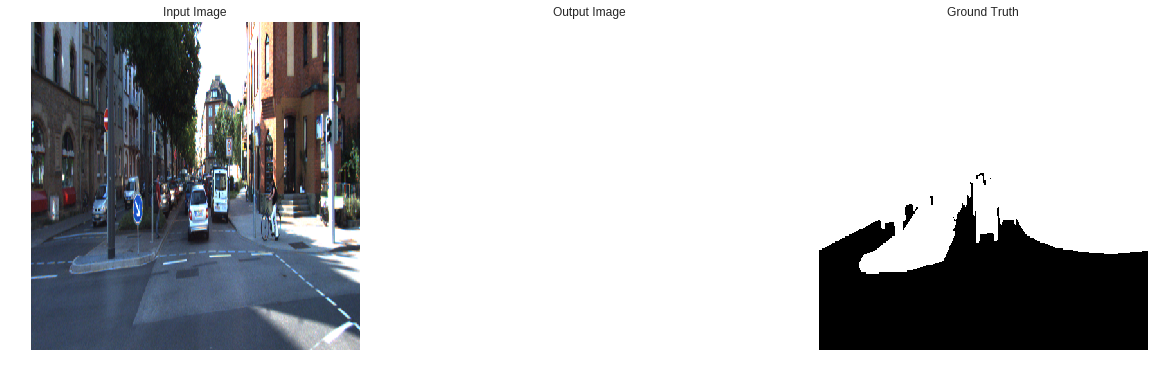

In [0]:
mno = 3
figure = plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.title('Input Image')
plt.axis('off')
plt.imshow(tmg_)
plt.subplot(1, 3, 2)
plt.title('Output Image')
plt.axis('off')
plt.imshow(out1[mno, :, :].cpu().detach().numpy())
plt.subplot(1, 3, 3)
plt.title('Ground Truth')
plt.axis('off')
plt.imshow(m_[mno, :, :])
plt.show()

In [0]:
_a = nn.Conv2d(16, 164, 3)

In [0]:
count_paramters(_a)

23780

In [0]:
# Save the parameters
checkpoint = {
    'epochs' : e,
    'state_dict' : enet.state_dict()
}
torch.save(checkpoint, 'ckpt-enet-1.pth')

In [0]:
# Save the model
torch.save(enet, '/content/model.pt')

In [0]:
enet.eval()

for inputs, labels in testloader:
    if cuda:
        inputs, labels = inputs.cuda(), labels.cuda()

    out = enet(inputs)

    enet.zero_grad()

    loss = criterion(inputs, labels)
    loss.backward()
    optimizer.step()


    train_losses.append(loss)

    if print_every % e == 0:
        print ('Epoch {}/{}'.format(e, epochs),
               'Loss {}'.format(loss))

In [0]:
def loader(training_path, segmented_path, batch_size):
    filenames_t = os.listdir(training_path)
    total_files_t = len(filenames_t)
    
    filenames_s = os.listdir(segmented_path)
    total_files_s = len(filenames_s)
    
    print (total_files_s)
    assert(total_files_t == total_files_s)
    
    idx = 0
    while(1):
        batch_idxs = np.random.randint(0, total_files_s, batch_size)
        
        inputs = []
        labels = []
        
        for jj in batch_idxs:
            img = plt.imread(training_path + filenames_t[jj])
            img = cv2.resize(img, (512, 512), cv2.INTER_CUBIC)
            inputs.append(img)
            
            img = plt.imread(segmented_path + filenames_s[jj])
            img = cv2.resize(img, (512, 512), cv2.INTER_NEAREST)
            labels.append(img)
         
        inputs = np.stack(inputs, axis=2)
        inputs = torch.tensor(inputs).transpose(0, 2).transpose(1, 3)
        
        labels = torch.tensor(labels)
        
        yield inputs, labels

In [0]:
def create_semantic(mask, color_map):
    assert(len(color_map) == mask.shape[0])
    
    h = mask.shape[1]
    w = mask.shape[2]
    fimg = np.zeros((h, w, 3))
    
    fimg = np.ones((h, w, 3))
    for ii in range(len(color_map)):
        cmask = np.logical_and(fimg, mask[ii, : :])
        
    for ii in range(len(color_map)):
        for hh in range(h):
            for ww in range(w):
                print (hh, ww, fimg[hh, ww, :])
                if fimg[hh, ww, :].sum() == 0:
                    fimg[hh, ww, :] = color_map[ii]
                else:
                    fimg[hh, ww, :] = [0, 0, 0]
                    
    return fimg

In [0]:
b_ = create_semantic(m_, color_map)

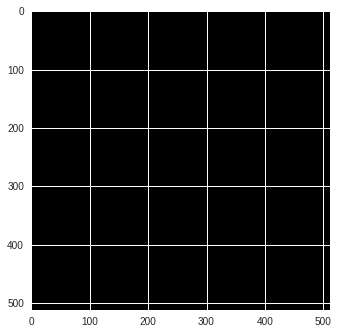

In [0]:
plt.imshow(b_)

In [0]:
pipe = loader('/content/training/image_2/', '/content/training/semantic/', batch_size)
images, labels = next(pipe)

200


In [0]:
images.shape

torch.Size([10, 3, 512, 512])

In [0]:
labels.shape

torch.Size([10, 512, 512])

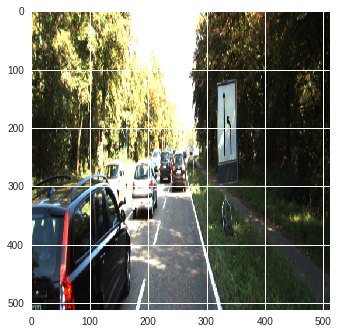

In [0]:
plt.imshow(images[9].transpose(0, 1).transpose(1, 2))

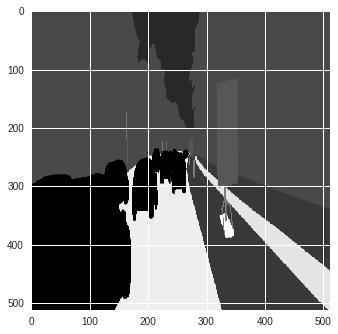

In [0]:
plt.imshow(labels[9])